# Integrals for the Hartree-Fock Approximation
<br></br>

## Nomenclature

<p>
    <br/>
    
Within this python script, the wave functions, $\psi$, that represent atomic wavefunctions are each composed of a set of contracted gaussians that are added lineary and multiplied by respective contraction coeffiecents to produce the wavefunction $\psi$. A gaussian is represented as $e^{-\alpha|R_A|^2}$.  When $\psi_1$ and $\psi_2$ are being integrated, $\int\psi_1\psi_2d\tau$, the resulting integral is the multiplication of two gaussians, such that the integration reduces to: $$[\dfrac{\pi}{(\alpha+\beta)}]^{\dfrac{3}{2}}\cdot e^{\dfrac{-\alpha\beta}{\alpha+\beta}\cdot|R_a-R_b|^2}$$

The rest of this description will focus upon explaining the meaning behind the nomenclature used in variable naming in this script in regrads to the above analytical expansion of $\int\psi_1\psi_2d\tau$.

$\alpha$ and $\beta$ both refer to the orbital coefficent of a gaussian that represents how widespread or narrow the gaussian will be. The sum of $\alpha+\beta$ is $p$, while the product of $\alpha\cdot\beta$ is $ab$. The variable <i>constant</i> refers to all constants that can be taken out of the integral and are multipled at the end of the analytical integration method, and is composed of the contraction coefficents for the gaussians, and the normalization constants, which are equal to
$(\dfrac{2\alpha}{\pi})^{3/4}$. Any variables named <i>c</i> followed by a number represent a constant that can be pulled out of the integral, and is multiplied into the general <i>constant</i> variable. Any variable with the name <i>distance</i> refers to the distance between two primative gaussians. <i>e</i> refers to some value that is taken to the power of $e$ and is multipled into the integral. <i>term</i> variables followed by a number represent a specific computaional portion of the integral that is placed into a variable to produce a more legible code. 
    
Located on Page 412 of Szabo.  
</p>

In [4]:
import math
from matplotlib import pyplot as plt

## Overlap Integral

<p> 
    <br/>
    The overlap integral describes the amount of overlap bwetween two atomic orbitals. The value ranges from 1 to 0, with zero meaning there is no overlap between the orbitals, and 1 meaning the orbitals are the same and overlap exactly. The overlap is used to determine bonding between atoms, and to construct the molecular orbitals. 
    <br/> 
    The overlap integral is computed as follows: 
    $$\int \Psi^*_A\Psi_B  d\tau $$
    Located on Page 412 of Szabo
</p>

In [2]:
def overlap(molecule):

    #init empty list for the overlap matrix
    S = [] 
    
    #get basis function for the molecule
    #is an array with all basis functions from the atoms in the molecule contained within it
    basis = molecule.getBasis()
    
    #iterate through all basisSets used in the molecule
    for index1, psi1 in enumerate(basis):
            S.append([])
            for index2, psi2 in enumerate(basis):
                S[index1].append(0)			

                #overlap integral is simply the integral of basis function 1 times basis function 2
                #is done with gaussians thorough gaussian multiplication, which results in a new 
                #gaussian which is then integrated analytically, 
                #and whose analytical equation is solved here for the overlap 

                #iterate through all contracted gaussians that compose psi1 and psi 2
                for cg1 in psi1.contractedGaussians:
                    for cg2 in psi2.contractedGaussians:

                        #get overlap contracted gaussian 
                        cg3 = cg1.multiply(cg2)

                        #get constant to multiply overlap integral by 
                        constant = cg3.constant * cg1.contraction * cg2.contraction

                        #compute overlap coefficent
                        S[index1][index2] += constant * pow((math.pi/cg3.orbitalExponet), 3/2) 	
    return S

## Kinetic Energy Integral
<p>
    <br />
    This integral computes the kinetic energy of the electrons, which is used in forming the electronic hamiltonian. 
    <br />
    The integral is as follows:
    $$ \int \psi^*_A  (-\frac{1}{2}\nabla^2) \psi_B d\tau $$
    Located on page 427 of Szabo.
</p>


In [3]:
def kineticEnergy(molecule):
    
    #init empty list for the kinetic energy matrix
    T = []
    
    basis = molecule.getBasis()
    
    #iterate through all basis functions used within the molecule
    for index1, psi1 in enumerate(basis):
        T.append([])
        
        for index2, psi2 in enumerate(basis):
            T[index1].append(0)		

            #KE integral computed by taking gaussian 1 times -1/2 del squared acting upon gaussian 2
            #equation located on page 427 of Szabo

            #iterate through all the contracted gaussians of psi1 and psi2 
            for cg1 in psi1.contractedGaussians:
                for cg2 in psi2.contractedGaussians:

                    ab = cg1.orbitalExponet * cg2.orbitalExponet
                    p = cg1.orbitalExponet + cg2.orbitalExponet
                    distanceSquared = pow((cg1.coord - cg2.coord).magnitude(), 2)
                    c1 = ab / p 
                    c2 = pow(math.pi / p, 3/2)
                    e = math.exp(-c1*distanceSquared)
                    constant = cg1.contraction * cg2.contraction * cg1.constant * cg2.constant * c1 * c2

                    T[index1][index2] += constant * (3 - (2*c1*distanceSquared) ) * e
    return T

## Error Function Definition
<p>
    <br/>
    The error function is defined below to be used in the Nuclear-Electron Attraction and Electron-Electron repulsion integrals.
</p>

In [15]:
def errorFunction(errorInput, distance):
    
    if(distance < 10**-70):
         return 1 - (errorInput/3)
    else:
         return 0.5 * pow(math.pi/errorInput, 0.5) * math.erf(pow(errorInput, 0.5))

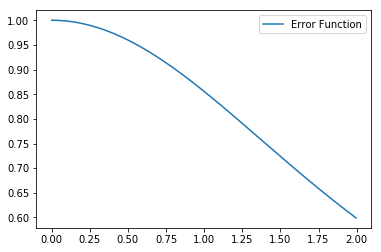

In [17]:
def plotErrorFunction(startRange=0, endRange=2, steps = 500):
    
    #set up variables for plotting
    deltaInput = (endRange - startRange) / steps
    errorInput = startRange
    inputs = []
    outputs = []
    
    while(errorInput <= endRange):
        
        #compute error output and append it to its respective list
        outputs.append(errorFunction((errorInput ** 2) * .5, errorInput))
        inputs.append(errorInput)
            
        errorInput += deltaInput

    #prepare and plot the error function 
    plt.plot(inputs, outputs, label="Error Function")
    plt.legend()

plotErrorFunction()

## Nuclear-Electron Attraction Integral
<p>
    <br />
    The nuclear-eclectron attraction integral computes the potential energy surface of the molecule in terms of the attractive forces between the nucli and the electrons. This integral is used to construct the electronic hamiltonian in conjunction with the kinetic energy integral. The final solution to the nuclear-electron attraction is approximated with the error function combined with an artificial asymptote at $R=0$.
    <br/>
    The integral is as follows:
    $$ \int \psi^*_A (-\frac{Z_c}{r_{c}}) \psi_B d\tau $$
    Located on page 429 of Szabo.
</p>

In [18]:
def nuclearAttraction(molecule):
    
    #init nuclear attraction matrix 
    #each nuclear attraction list is composed of 1 matrix for each atom in the molecule, which includes a psi x psi matrix of values from the primative gaussian compuatation 
    V = []

    basis = molecule.getBasis()
    
    #used for graphing purposes
    distances = []
    errorInputs = []
    errorValues = []
    
    #iterate through all atoms for Z
    for atomIndex, atom in enumerate(molecule.atomData):        
        V.append([])

        #prepare graph lists
        distances.append([])
        errorInputs.append([])
        errorValues.append([])

        #iterate through all basis functions used
        for index1, psi1 in enumerate(basis):
            V[atomIndex].append([])

            #prepare graph lists
            distances[atomIndex].append([])
            errorInputs[atomIndex].append([])
            errorValues[atomIndex].append([])

            for index2, psi2 in enumerate(basis):
                V[atomIndex][index1].append(0)

                #prepare graph lists
                distances[atomIndex][index1].append([])
                errorInputs[atomIndex][index1].append([])
                errorValues[atomIndex][index1].append([])

                #iterate through all the primative gaussians
                for cg1 in psi1.contractedGaussians:
                    for cg2 in psi2.contractedGaussians:

                        #compute data needed for the integral
                        ab = cg1.orbitalExponet * cg2.orbitalExponet
                        p = cg1.orbitalExponet + cg2.orbitalExponet
                        e = (-ab/p) *  pow((cg1.coord - cg2.coord).magnitude(), 2)
                        c1 = (-2 * math.pi) / p
                        cg3 = cg1.multiply(cg2)

                        constant = cg1.contraction * cg2.contraction * c1 * atom.Z * math.exp(e)
                        errorInput = p * math.pow((cg3.coord - atom.coord).magnitude(), 2)

                        #error input cutoff and else equation from Szabo pg. 437
                        #use first error equation to simulate asymptote for very small values
                        #but, due to numerical errors with python, small numbers only occurs 
                        #if index1==index2, but sometimes, such values may be larger,
                        #resulting in a negative error that is remedied by the second error equation
                        electronNuclearDistance = (cg3.coord - atom.coord).magnitude()
                        error = errorFunction(errorInput, electronNuclearDistance)

                        #add data for graphing purposes
                        distances[atomIndex][index1][index2].append(electronNuclearDistance)
                        errorInputs[atomIndex][index1][index2].append(errorInput)
                        errorValues[atomIndex][index1][index2].append(error)

                        V[atomIndex][index1][index2] += constant * error * cg1.constant * cg2.constant 

    return V

## Electron-Electron Repulsion Integral

<p>
    <br/>
    This integral computes the energy that each electrons feels towards all other electrons near it. Also called the four center integral because it involves integrating over four wavefunctions simultaneously.
    <br/>
    The integral is as follows: $$\int\psi^*_{A1}\psi^*_{B1}(\dfrac{1}{r_{12}})\psi_{C2}\psi_{D3} d\tau_1d\tau_2$$
</p>

In [7]:
def electronElectronRepulsion(molecule):
    
    #init electron-electron repulsion list 
    #constructs a tensor equal to the size of the basis set squared
    electronRepulsion = []

    basis = molecule.getBasis()
    
    #iterate through PsiA1PsiA2 and PsiB1PsiB2
    for index1, psi1 in enumerate(basis):
        electronRepulsion.append([])
        for index2, psi2 in enumerate(basis):
            electronRepulsion[index1].append([])
            
            for index3, psi3 in enumerate(basis):
                electronRepulsion[index1][index2].append([])
                for index4, psi4 in enumerate(basis):
                    electronRepulsion[index1][index2][index3].append(0)

                    #iterate through all of the primative gaussians for each of the wavefunctions
                    for cg1 in psi1.contractedGaussians:
                        for cg2 in psi2.contractedGaussians:
                            for cg3 in psi3.contractedGaussians:
                                for cg4 in psi4.contractedGaussians:

                                    pA = cg1.orbitalExponet + cg2.orbitalExponet
                                    pB = cg3.orbitalExponet + cg4.orbitalExponet
                                    abA = cg1.orbitalExponet * cg2.orbitalExponet
                                    abB = cg3.orbitalExponet * cg4.orbitalExponet
                                    
                                    pAB = pA + pB

                                    term1 = (2 * pow(math.pi, 5/2)) / (pA*pB*pow(pAB, 1/2))
                                    distanceAB = pow( (cg1.coord - cg2.coord).magnitude(), 2)
                                    distanceCD = pow( (cg3.coord - cg4.coord).magnitude(), 2)
                                    e = ((-abA/pA) * distanceAB) - ( (abB/pB) * distanceCD )
                                    cgAB = cg1.multiply(cg2)
                                    cgCD = cg3.multiply(cg4)
                                    distanceABCD = (cgAB.coord - cgCD.coord).magnitude()
                                    errorInput = ( (pA * pB) / pAB) * pow(distanceABCD, 2)
                                    error = errorFunction(errorInput, distanceABCD)
        
                                    constant = cg1.constant * cg2.constant * cg3.constant * cg4.constant * cg1.contraction * cg2.contraction * cg3.contraction * cg4.contraction
                                   
                                    electronRepulsion[index1][index2][index3][index4] += term1 * math.exp(e) * error * constant
    return electronRepulsion                    